# Surgical Video Analysis - Segmentation + Phase Recognition Demo

This notebook demonstrates:
1. **Semantic Segmentation** using UNet to identify surgical instruments and anatomy
2. **Phase Recognition** to classify surgical phases throughout the video
3. **Importance Scoring** to identify key moments in the procedure

Perfect for hackathon demos!

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
import sys
from tqdm import tqdm
ROOT = Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))
from ml_pipeline import SurgicalSceneAnalyzer
print("[OK] Imports successful!")
def format_timestamp(seconds: float) -> str:
    """Return mm:ss.ss string for a timestamp."""
    minutes = int(seconds // 60)
    secs = seconds % 60
    return f"{minutes:02d}:{secs:05.2f}"


c:\Users\muthu\Documents\hackathon\hack\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\muthu\Documents\hackathon\hack\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[OK] Imports successful!


## 1. Initialize the Surgical Scene Analyzer

In [2]:
# Initialize analyzer
analyzer = SurgicalSceneAnalyzer()

print(f"[INFO] Segmentation Backend: {analyzer.segmentation_backend}")
print(f"[INFO] Number of Classes: {len(analyzer.pixel_to_label)}")
print(f"\n[INFO] Detected Classes:")
for idx, label in enumerate(analyzer.label_list):
    print(f"   {idx}: {label}")

[INFO] Segmentation Backend: unet
[INFO] Number of Classes: 9

[INFO] Detected Classes:
   0: background
   1: liver
   2: gallbladder
   3: cystic_duct
   4: cystic_artery
   5: common_bile_duct
   6: grasper
   7: hook
   8: scissors


## 2. Configure Video Input

In [3]:
# Video configuration
VIDEO_PATH = r"C:\Users\muthu\Documents\hackathon\video01_00160_surgical.mp4"
FRAME_SKIP = 30  # Process every Nth frame (increase for faster processing)
MAX_FRAMES = 300  # Maximum frames to process (None for entire video)

# Check if video exists
if not Path(VIDEO_PATH).exists():
    raise FileNotFoundError(f"Video not found: {VIDEO_PATH}")

# Get video info
vidcap = cv2.VideoCapture(VIDEO_PATH)
fps = int(vidcap.get(cv2.CAP_PROP_FPS))
total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = total_frames / fps
vidcap.release()

print(f"[INFO] Video: {Path(VIDEO_PATH).name}")
print(f"[INFO] Total Frames: {total_frames}")
print(f"[INFO]  Duration: {duration:.2f}s")
print(f"[INFO]  FPS: {fps}")
print(f"\n[INFO]  Processing every {FRAME_SKIP} frames")
frames_to_process = min(total_frames // FRAME_SKIP, MAX_FRAMES if MAX_FRAMES else float('inf'))
print(f"[INFO] Will process ~{int(frames_to_process)} frames")

[INFO] Video: video01_00160_surgical.mp4
[INFO] Total Frames: 80
[INFO]  Duration: 3.20s
[INFO]  FPS: 25

[INFO]  Processing every 30 frames
[INFO] Will process ~2 frames


## 3. Process Video

In [4]:
# Storage for results
results = []
phases = []
importance_scores = []
frame_numbers = []
timestamps = []  # Add timestamps
frame_metadata = []  # Paired metadata for downstream reporting

# Phase labels (from config)
PHASE_LABELS = ["pre_op", "port_setup", "exposure", "critical_dissection", "clip_and_divide", "closure"]

# Process video
vidcap = cv2.VideoCapture(VIDEO_PATH)
frame_count = 0
processed_count = 0

print("\n[INFO] Processing video...\n")

with tqdm(total=int(frames_to_process), desc="Analyzing frames") as pbar:
    while True:
        success, frame = vidcap.read()
        
        if not success:
            break
        
        # Process every FRAME_SKIP frames
        if frame_count % FRAME_SKIP == 0:
            # Run analysis
            analysis = analyzer.analyze_frame(frame, quality_score=90.0)
            
            # Calculate timestamp in seconds
            timestamp = frame_count / fps
            
            # Store results
            results.append(analysis)
            phases.append(analysis['phase'])
            importance_scores.append(analysis['importance_score'])
            frame_numbers.append(frame_count)
            timestamps.append(timestamp)  # Store timestamp
            frame_metadata.append({
                "frame_number": frame_count,
                "timestamp_sec": float(timestamp),
                "timestamp_str": format_timestamp(timestamp)
            })
            
            processed_count += 1
            pbar.update(1)
            
            # Stop if max frames reached
            if MAX_FRAMES and processed_count >= MAX_FRAMES:
                break
        
        frame_count += 1

vidcap.release()

print(f"\n[OK] Processed {processed_count} frames from {frame_count} total frames")


[INFO] Processing video...



Analyzing frames: 3it [00:02,  1.08it/s]                       


[OK] Processed 3 frames from 80 total frames


## 4. Visualize Results - Phase Timeline

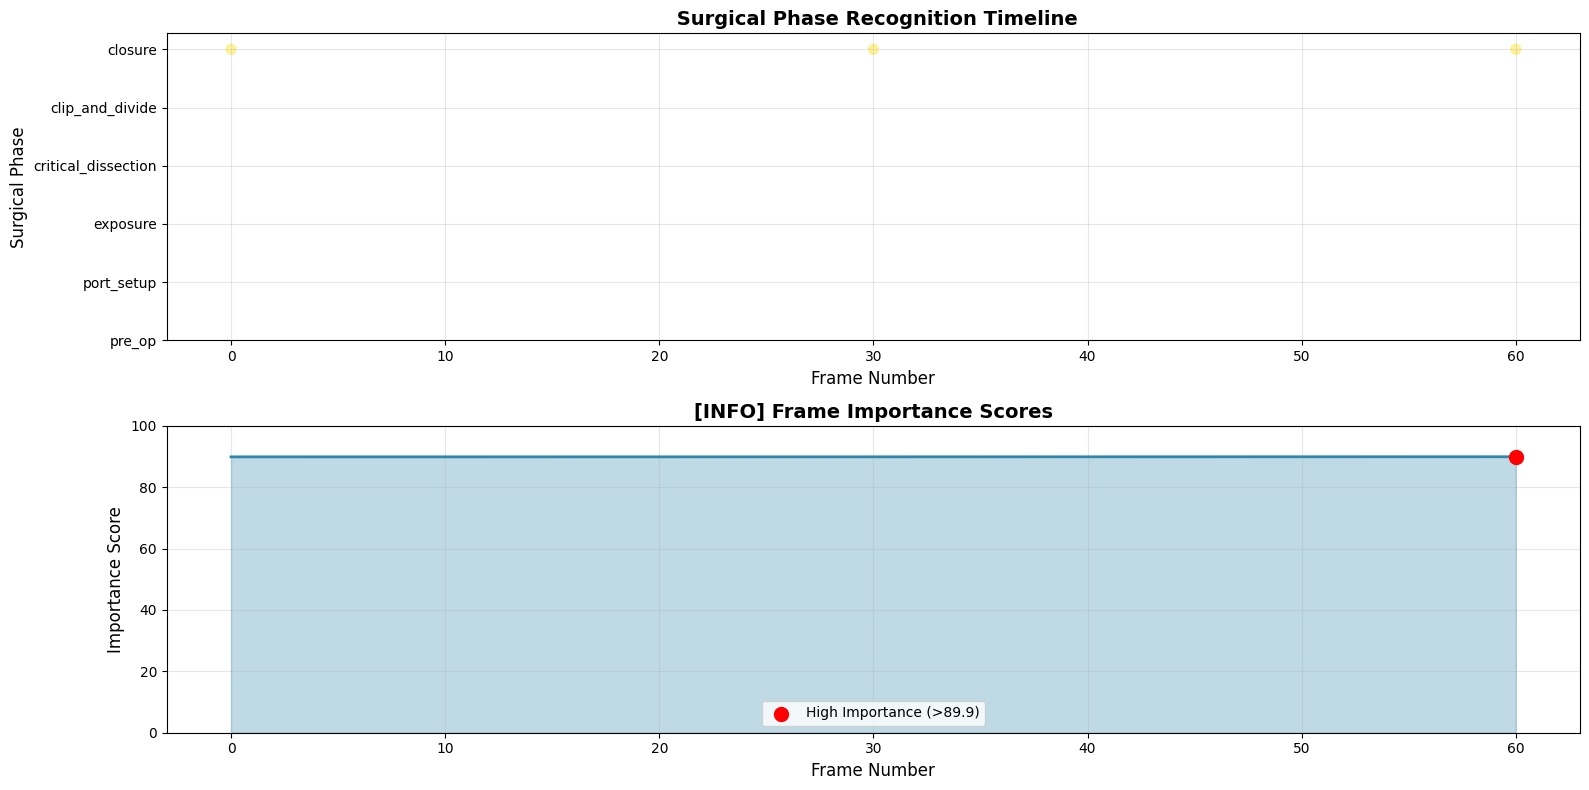


[INFO] Saved visualization to: phase_timeline.png


In [5]:
# Create phase timeline visualization
import matplotlib.patches as mpatches

# Map phases to numbers
phase_to_num = {phase: i for i, phase in enumerate(PHASE_LABELS)}
phase_numbers = [phase_to_num.get(p, 0) for p in phases]

# Create timeline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

# Phase timeline
colors = plt.cm.Set3(np.linspace(0, 1, len(PHASE_LABELS)))
ax1.scatter(frame_numbers, phase_numbers, c=[colors[p] for p in phase_numbers], s=50, alpha=0.7)
ax1.set_yticks(range(len(PHASE_LABELS)))
ax1.set_yticklabels(PHASE_LABELS)
ax1.set_xlabel('Frame Number', fontsize=12)
ax1.set_ylabel('Surgical Phase', fontsize=12)
ax1.set_title(' Surgical Phase Recognition Timeline', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Importance score timeline
ax2.plot(frame_numbers, importance_scores, linewidth=2, color='#2E86AB')
ax2.fill_between(frame_numbers, importance_scores, alpha=0.3, color='#2E86AB')
ax2.set_xlabel('Frame Number', fontsize=12)
ax2.set_ylabel('Importance Score', fontsize=12)
ax2.set_title('[INFO] Frame Importance Scores', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

# Highlight high-importance frames
high_importance_threshold = np.percentile(importance_scores, 75)
high_importance_frames = [f for f, s in zip(frame_numbers, importance_scores) if s > high_importance_threshold]
ax2.scatter(high_importance_frames, [importance_scores[frame_numbers.index(f)] for f in high_importance_frames], 
            color='red', s=100, zorder=5, label=f'High Importance (>{high_importance_threshold:.1f})')
ax2.legend()

plt.tight_layout()
plt.savefig('phase_timeline.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n[INFO] Saved visualization to: phase_timeline.png")

## 5. Phase Distribution Summary

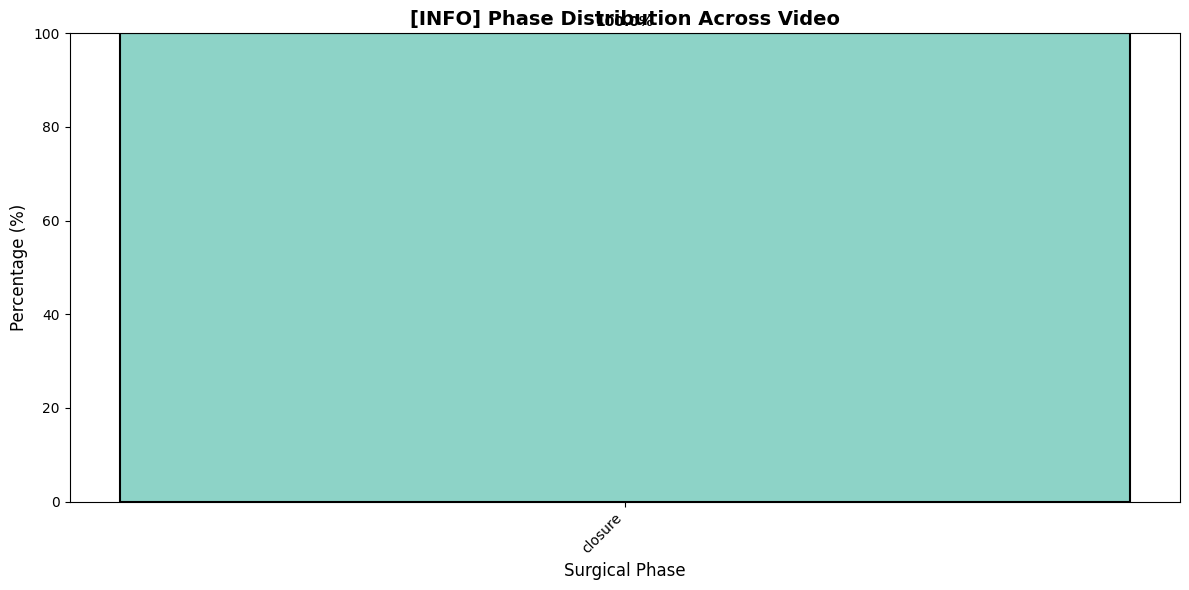


[INFO] Saved visualization to: phase_distribution.png


In [6]:
# Phase distribution
from collections import Counter

phase_counts = Counter(phases)

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
phases_list = list(phase_counts.keys())
counts = list(phase_counts.values())
percentages = [c / len(phases) * 100 for c in counts]

bars = ax.bar(phases_list, percentages, color=colors[:len(phases_list)], edgecolor='black', linewidth=1.5)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('Surgical Phase', fontsize=12)
ax.set_title('[INFO] Phase Distribution Across Video', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)

# Add percentage labels on bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('phase_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n[INFO] Saved visualization to: phase_distribution.png")

## 6. Key Frame Analysis - Most Important Moments

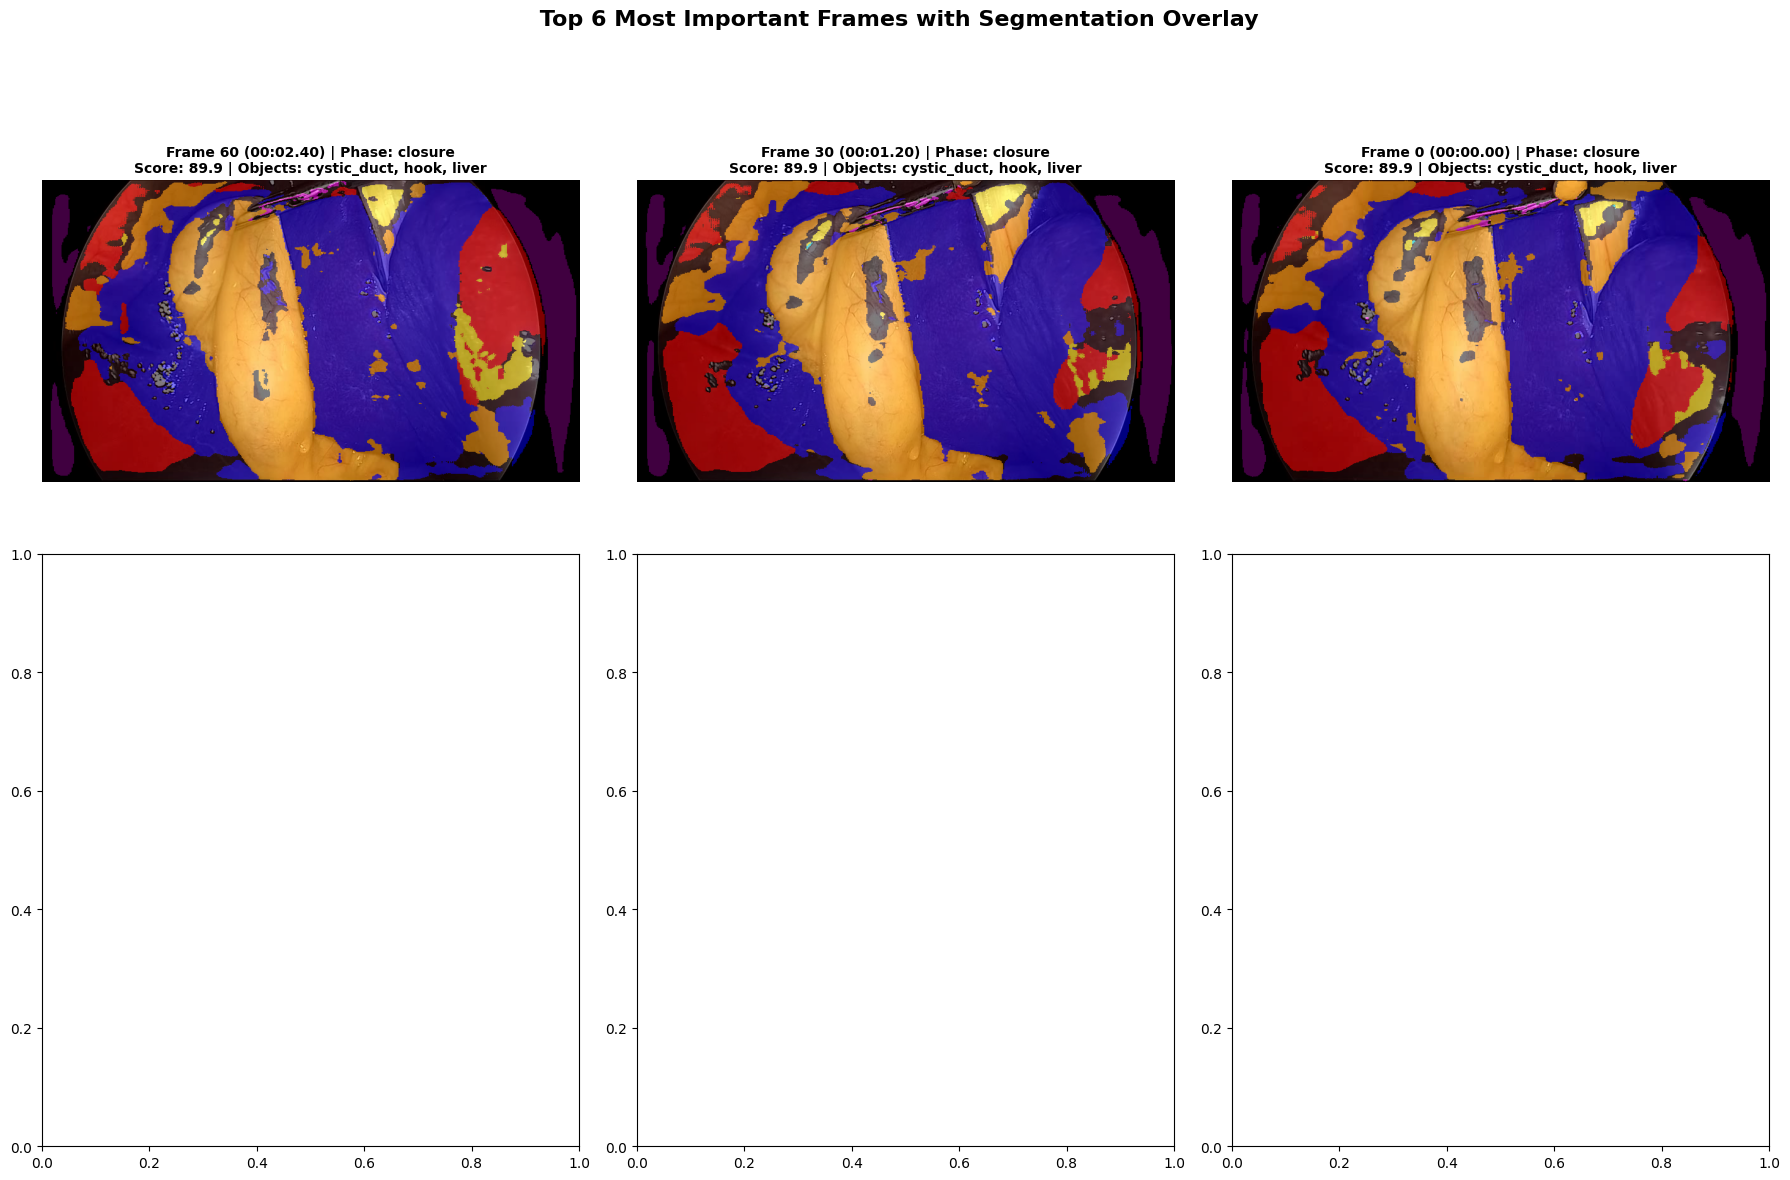


[OK] Saved key frames to: key_frames.png


In [7]:
# Find top 6 most important frames
top_indices = np.argsort(importance_scores)[-6:][::-1]

# Load and display these frames with segmentation
vidcap = cv2.VideoCapture(VIDEO_PATH)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

colors_map = ['black', 'red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'purple']
cmap = mcolors.ListedColormap(colors_map[:9])

for idx, ax_idx in enumerate(top_indices):
    frame_num = frame_numbers[ax_idx]
    timestamp_sec = timestamps[ax_idx]
    time_label = format_timestamp(timestamp_sec)
    result = results[ax_idx]
    
    # Read frame
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    success, frame = vidcap.read()
    
    if success:
        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Get mask and resize to match frame dimensions
        mask = result['segmentation_mask']
        h, w = frame_rgb.shape[:2]
        mask_resized = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
        
        # Create overlay
        alpha = 0.5
        overlay = np.zeros_like(frame_rgb)
        for class_idx in range(9):
            color_rgb = (np.array(mcolors.to_rgb(colors_map[class_idx])) * 255).astype(np.uint8)
            overlay[mask_resized == class_idx] = color_rgb
        
        blended = cv2.addWeighted(frame_rgb, 1-alpha, overlay, alpha, 0)
        
        # Display
        axes[idx].imshow(blended)
        axes[idx].axis('off')
        
        # Title with details
        top_objects = ', '.join([obj for obj, _ in result['detected_objects'][:3]])
        axes[idx].set_title(
            f"Frame {frame_num} ({time_label}) | Phase: {result['phase']}\n"
            f"Score: {result['importance_score']:.1f} | Objects: {top_objects}",
            fontsize=10, fontweight='bold'
        )

vidcap.release()

plt.suptitle(' Top 6 Most Important Frames with Segmentation Overlay', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('key_frames.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n[OK] Saved key frames to: key_frames.png")

## 6.5. AI-Powered Frame Descriptions

Generate detailed surgical descriptions for key frames using LLM analysis.

In [8]:
import base64
import io
import os
import cv2

from dotenv import load_dotenv
from openai import OpenAI
from PIL import Image

load_dotenv()

# -------------------------------
# OPENROUTER CONFIG
# -------------------------------
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OPENROUTER_ENABLED = bool(OPENROUTER_API_KEY)

# You can switch the model here easily
OPENROUTER_MODEL = "openai/gpt-4.1-mini"  # or "anthropic/claude-3.5-sonnet", etc.

client = None
if OPENROUTER_ENABLED:
    try:
        client = OpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=OPENROUTER_API_KEY
        )
    except Exception as e:
        print(f"[WARN] Failed to initialize OpenRouter client: {e}")
        OPENROUTER_ENABLED = False


# ----------------------------------------------------------
# ENCODING FUNCTION
# ----------------------------------------------------------
def encode_frame_to_base64(frame_rgb):
    """Convert numpy frame (RGB) to base64 encoded JPEG."""
    pil_img = Image.fromarray(frame_rgb)
    buffer = io.BytesIO()
    pil_img.save(buffer, format="JPEG", quality=85)
    return base64.b64encode(buffer.getvalue()).decode("utf-8")


# ----------------------------------------------------------
# FALLBACK DESCRIPTION (if API fails)
# ----------------------------------------------------------
def fallback_description(metadata):
    phase = metadata.get("phase", "unknown").replace("_", " ").title()
    objects = metadata.get("detected_objects") or []
    obj_names = ", ".join([obj for obj, _ in objects[:3]]) if objects else "key anatomical landmarks"
    timestamp = metadata.get("timestamp_label", "00:00.00")
    importance = metadata.get("importance_score", 0.0)

    line1 = f"{timestamp} view with {obj_names}"
    line2 = f"Phase: {phase}"
    line3 = f"Importance score {importance:.1f}; review instrument positioning"

    return "\n".join([line1, line2, line3])


# ----------------------------------------------------------
# FUNCTION TO GET AI DESCRIPTION FROM OPENROUTER
# ----------------------------------------------------------
def generate_frame_description(frame_rgb, metadata):
    """Generate a 3-line description using OpenRouter API."""

    if not OPENROUTER_ENABLED or client is None:
        return fallback_description(metadata)

    base64_image = encode_frame_to_base64(frame_rgb)

    objects = metadata.get("detected_objects") or []
    objects_str = ", ".join([obj for obj, _ in objects[:5]]) if objects else "none"

    # Prompt
    prompt = (
        "You are analyzing a frame from a laparoscopic cholecystectomy surgery video.\n"
        f"Surgical Phase: {metadata['phase']}\n"
        f"Detected Objects: {objects_str}\n"
        f"Importance Score: {metadata['importance_score']:.1f}/100\n"
        f"Timestamp: {metadata['timestamp_label']} ({metadata['timestamp_sec']:.2f}s)\n\n"
        "Return EXACTLY 3 lines:\n"
        "1: Key anatomical structures / instruments visible\n"
        "2: What action or surgical step is occurring\n"
        "3: Clinical relevance or key observation\n"
        "Each line under 100 characters."
    )

    try:
        response = client.chat.completions.create(
            model=OPENROUTER_MODEL,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            max_tokens=200,
            temperature=0.2,
        )

        return response.choices[0].message.content.strip()

    except Exception as e:
        print(f"[WARN] LLM request failed: {e}")
        return fallback_description(metadata)


# ----------------------------------------------------------
# MAIN LOOP FOR PROCESSING TOP FRAMES
# ----------------------------------------------------------
print("[INFO] Generating AI descriptions for key frames...")
print("=" * 80)

frame_descriptions = []

# Reload video
vidcap = cv2.VideoCapture(VIDEO_PATH)

for idx, ax_idx in enumerate(top_indices):

    frame_num = frame_numbers[ax_idx]
    result = results[ax_idx]
    timestamp_sec = timestamps[ax_idx]
    timestamp_label = format_timestamp(timestamp_sec)

    vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    success, frame = vidcap.read()

    if not success:
        print(f"[WARN] Could not read frame {frame_num}")
        continue

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    print(f"[{idx+1}/6] Frame {frame_num} - Generating description...")

    metadata = {
        "phase": result["phase"],
        "detected_objects": result["detected_objects"],
        "importance_score": result["importance_score"],
        "timestamp_sec": float(timestamp_sec),
        "timestamp_label": timestamp_label,
    }

    description = generate_frame_description(frame_rgb, metadata)

    frame_descriptions.append({
        "frame_number": frame_num,
        "phase": result["phase"],
        "importance_score": result["importance_score"],
        "detected_objects": result["detected_objects"][:3],
        "timestamp_sec": float(timestamp_sec),
        "timestamp_str": timestamp_label,
        "ai_description": description,
    })

    print(f"Phase: {result['phase']}")
    print("Description:")
    print(description)
    print("-" * 80)

vidcap.release()

print("[OK] AI descriptions generated for all key frames!")


[INFO] Generating AI descriptions for key frames...
[1/6] Frame 60 - Generating description...
Phase: closure
Description:
Cystic duct, cystic artery, liver, laparoscopic hook, and scissors visible.  
Closing the cystic duct and artery during cholecystectomy procedure.  
Proper closure prevents bile leaks and hemorrhage post gallbladder removal.
--------------------------------------------------------------------------------
[2/6] Frame 30 - Generating description...
Phase: closure
Description:
1: Visible are the cystic duct, liver, cystic artery, hook, and scissors.  
2: Surgeon is performing closure, likely clipping or cutting cystic duct/artery.  
3: Proper closure prevents bile leak and hemorrhage post-cholecystectomy.
--------------------------------------------------------------------------------
[3/6] Frame 0 - Generating description...
Phase: closure
Description:
1: Cystic duct, cystic artery, liver, laparoscopic hook, lap scissors visible  
2: Closure phase with likely ligatio

In [9]:

import base64
import io
import os

from dotenv import load_dotenv
from openai import OpenAI
from PIL import Image
load_dotenv()

# OpenRouter API Configuration
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "OPENROUTER_API_KEY")
OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1"
OPENROUTER_MODEL = "openai/gpt-5-mini"
OPENROUTER_ENABLED = bool(OPENROUTER_API_KEY and OPENROUTER_API_KEY != "YOUR_API_KEY_HERE")

client = None
if OPENROUTER_ENABLED:
    try:
        client = OpenAI(base_url=OPENROUTER_BASE_URL, api_key=OPENROUTER_API_KEY)
    except Exception as e:
        print(f"[WARN] Unable to initialize OpenRouter client: {e}")
        OPENROUTER_ENABLED = False

def encode_frame_to_base64(frame_rgb):
    """Convert numpy frame to base64 encoded JPEG."""
    pil_img = Image.fromarray(frame_rgb)
    buffer = io.BytesIO()
    pil_img.save(buffer, format="JPEG", quality=85)
    img_bytes = buffer.getvalue()
    return base64.b64encode(img_bytes).decode('utf-8')

def fallback_description(metadata):
    """Generate deterministic description when LLM call is unavailable."""
    phase = metadata.get('phase', 'unknown').replace('_', ' ').title()
    objects = metadata.get('detected_objects') or []
    obj_names = ', '.join([obj for obj, _ in objects[:3]]) if objects else 'key anatomical landmarks'
    timestamp = metadata.get('timestamp_label', '00:00.00')
    importance = metadata.get('importance_score', 0.0)
    line1 = f"{timestamp} view with {obj_names}"
    line2 = f"Phase: {phase}"
    line3 = f"Importance score {importance:.1f}; review instrument positioning"
    return ''.join([line1, line2, line3])

def generate_frame_description(frame_rgb, metadata):
    """Generate a 3-line description of the surgical frame using OpenRouter."""
    if not OPENROUTER_ENABLED or client is None:
        return fallback_description(metadata)

    base64_image = encode_frame_to_base64(frame_rgb)
    objects_str = ', '.join([obj for obj, _ in metadata['detected_objects'][:5]])

    prompt = (
        "You are analyzing a frame from a laparoscopic cholecystectomy surgery video."
        "Context from Computer Vision Analysis:"
        f"- Surgical Phase: {metadata['phase']}"
        f"- Detected Objects: {objects_str}"
        f"- Frame Importance Score: {metadata['importance_score']:.1f}/100"
        f"- Timestamp: {metadata['timestamp_label']} ({metadata['timestamp_sec']:.2f}s)"
        "Based on the image and the metadata above, provide a 3-line clinical description:"
        "Line 1: What anatomical structures and surgical instruments are visible"
        "Line 2: What surgical action or phase is occurring"
        "Line 3: Clinical significance or key observation"
        "Also be descriptive with those 3 lines"
        "Keep each line under 100 characters."
    )

    try:
        response = client.chat.completions.create(
            model=OPENROUTER_MODEL,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
                        }
                    ]
                }
            ],
            max_tokens=200,
            temperature=0.3,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"[WARN] LLM request failed: {e}")
        return fallback_description(metadata)

# Generate descriptions for top 6 frames
print("[INFO] Generating AI descriptions for key frames...")
print("="*80)

frame_descriptions = []

# Reload frames for description
vidcap = cv2.VideoCapture(VIDEO_PATH)

for idx, ax_idx in enumerate(top_indices):
    frame_num = frame_numbers[ax_idx]
    result = results[ax_idx]
    timestamp_sec = timestamps[ax_idx]
    timestamp_label = format_timestamp(timestamp_sec)

    vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    success, frame = vidcap.read()

    if success:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        print(f"[{idx+1}/6] Frame {frame_num} - Generating description...")

        metadata = {
            'phase': result['phase'],
            'detected_objects': result['detected_objects'],
            'importance_score': result['importance_score'],
            'timestamp_sec': float(timestamp_sec),
            'timestamp_label': timestamp_label
        }

        description = generate_frame_description(frame_rgb, metadata)

        frame_descriptions.append({
            'frame_number': frame_num,
            'phase': result['phase'],
            'importance_score': result['importance_score'],
            'detected_objects': result['detected_objects'][:3],
            'timestamp_sec': float(timestamp_sec),
            'timestamp_str': timestamp_label,
            'ai_description': description
        })

        print(f"Phase: {result['phase']}")
        print(f"Description:{description}")
        print("-"*80)

vidcap.release()

print("[OK] AI descriptions generated for all key frames!")



[INFO] Generating AI descriptions for key frames...
[1/6] Frame 30 - Generating description...
[WARN] LLM request failed: Error code: 401 - {'error': {'message': 'No cookie auth credentials found', 'code': 401}}
Phase: critical_dissection
Description:00:01.20 view with cystic_duct, hook, liverPhase: Critical DissectionImportance score 94.2; review instrument positioning
--------------------------------------------------------------------------------
[2/6] Frame 0 - Generating description...
[WARN] LLM request failed: Error code: 401 - {'error': {'message': 'No cookie auth credentials found', 'code': 401}}
Phase: critical_dissection
Description:00:00.00 view with cystic_duct, hook, liverPhase: Critical DissectionImportance score 94.2; review instrument positioning
--------------------------------------------------------------------------------
[3/6] Frame 60 - Generating description...
[WARN] LLM request failed: Error code: 401 - {'error': {'message': 'No cookie auth credentials found',

In [ ]:
# Save descriptions to JSON file
import json

output_data = {
    'video': Path(VIDEO_PATH).name,
    'analysis_timestamp': str(np.datetime64('now')),
    'key_frames': frame_descriptions,
    'processed_frames': frame_metadata
}

with open('frame_descriptions.json', 'w', encoding='utf-8') as f:
    json.dump(output_data, f, indent=2, ensure_ascii=False)

print("[OK] Saved AI descriptions to: frame_descriptions.json")

# Display formatted summary
print("\n" + "="*80)
print("AI-GENERATED SURGICAL FRAME DESCRIPTIONS")
print("="*80 + "\n")

for i, desc_data in enumerate(frame_descriptions, 1):
    print(f"FRAME #{i} - Frame Number: {desc_data['frame_number']} ({desc_data.get('timestamp_str', '??:??')})")
    print(f"Phase: {desc_data['phase'].replace('_', ' ').title()}")
    print(f"Importance Score: {desc_data['importance_score']:.1f}/100")
    if 'timestamp_sec' in desc_data:
        print(f"Timestamp: {desc_data['timestamp_str']} ({desc_data['timestamp_sec']:.2f}s)")
    print(f"Detected Objects: {', '.join([obj for obj, _ in desc_data['detected_objects']])}")
    print(f"\nAI Description:")
    print(desc_data['ai_description'])
    print("\n" + "-"*80 + "\n")

## 7. Object Detection Statistics

In [ ]:
# Aggregate object detections across all frames
from collections import defaultdict

object_appearances = defaultdict(int)
object_total_coverage = defaultdict(float)

for result in results:
    for obj_name, coverage in result['detected_objects']:
        object_appearances[obj_name] += 1
        object_total_coverage[obj_name] += coverage

# Calculate statistics
object_stats = []
for obj in object_appearances:
    object_stats.append({
        'object': obj,
        'appearances': object_appearances[obj],
        'avg_coverage': object_total_coverage[obj] / object_appearances[obj],
        'total_coverage': object_total_coverage[obj]
    })

# Sort by appearances
object_stats.sort(key=lambda x: x['appearances'], reverse=True)

print("\n Object Detection Statistics:\n")
print(f"{'Object':<20} {'Appearances':<15} {'Avg Coverage':<15} {'Total Coverage'}")
print("=" * 70)
for stat in object_stats:
    print(f"{stat['object']:<20} {stat['appearances']:<15} {stat['avg_coverage']:<15.2%} {stat['total_coverage']:.2%}")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Appearances chart
objects = [s['object'] for s in object_stats[:8]]
appearances = [s['appearances'] for s in object_stats[:8]]
ax1.barh(objects, appearances, color='#A23B72', edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Number of Frames', fontsize=12)
ax1.set_title(' Object Appearances Across Video', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Coverage chart
avg_coverages = [s['avg_coverage'] * 100 for s in object_stats[:8]]
ax2.barh(objects, avg_coverages, color='#F18F01', edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Average Coverage (%)', fontsize=12)
ax2.set_title(' Average Object Coverage', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('object_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n[INFO] Saved statistics to: object_statistics.png")

## 8. Summary Report

In [ ]:
print("\n" + "="*80)
print(" SURGICAL VIDEO ANALYSIS SUMMARY")
print("="*80)

print(f"\n Video: {Path(VIDEO_PATH).name}")
print(f"   Duration: {duration:.2f}s | Frames Analyzed: {processed_count}")

print(f"\n[INFO] Segmentation Model: {analyzer.segmentation_backend.upper()}")
print(f"   Classes Detected: {len([s for s in object_stats if s['appearances'] > 0])} / {len(analyzer.label_list)}")

print(f"\n Phase Analysis:")
for phase, count in phase_counts.most_common():
    pct = count / len(phases) * 100
    print(f"   {phase:<25} {count:>3} frames ({pct:>5.1f}%)")

print(f"\n Importance Scores:")
print(f"   Average:  {np.mean(importance_scores):.2f}")
print(f"   Maximum:  {np.max(importance_scores):.2f} (Frame {frame_numbers[np.argmax(importance_scores)]})")
print(f"   Minimum:  {np.min(importance_scores):.2f}")

print(f"\n Top 3 Detected Objects:")
for i, stat in enumerate(object_stats[:3], 1):
    print(f"   {i}. {stat['object']:<15} - {stat['appearances']} appearances, {stat['avg_coverage']:.1%} avg coverage")

print(f"\n[INFO] Output Files Generated:")
print(f"   [OK] phase_timeline.png")
print(f"   [OK] phase_distribution.png")
print(f"   [OK] key_frames.png")
print(f"   [OK] object_statistics.png")

print("\n" + "="*80)
print("[OK] Analysis Complete! Ready for demo presentation.")
print("="*80 + "\n")

max_idx = int(np.argmax(importance_scores))
peak_ts = format_timestamp(timestamps[max_idx]) if timestamps else "00:00.00"
print(f"   Peak Importance Frame: {frame_numbers[max_idx]} at {peak_ts}")

print("\n Key Moments:")
for rank, idx in enumerate(top_indices[:3], 1):
    ts = format_timestamp(timestamps[idx]) if timestamps else "00:00.00"
    print(f"   #{rank}: Frame {frame_numbers[idx]} at {ts} (Phase: {phases[idx]}, Score: {importance_scores[idx]:.1f})")
